In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

tf.enable_eager_execution()


In [2]:
tf.executing_eagerly() 


True

In [3]:
x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))

hello, [[4.]]


In [4]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [5]:
# Broadcasting support
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [6]:
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [7]:
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [8]:
print(a.numpy())

[[1 2]
 [3 4]]


In [9]:
tfe = tf.contrib.eager


In [10]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [11]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


In [12]:
class MySimpleLayer(tf.keras.layers.Layer):
  def __init__(self, output_units):
    super(MySimpleLayer, self).__init__()
    self.output_units = output_units

  def build(self, input_shape):
    # The build method gets called the first time your layer is used.
    # Creating variables on build() allows you to make their shape depend
    # on the input shape and hence removes the need for the user to specify
    # full shapes. It is possible to create variables during __init__() if
    # you already know their full shapes.
    self.kernel = self.add_variable(
      "kernel", [input_shape[-1], self.output_units])

  def call(self, input):
    # Override call() instead of __call__ so we can perform some bookkeeping.
    return tf.matmul(input, self.kernel)

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, input_shape=(784,)),  # must declare input shape
  tf.keras.layers.Dense(10)
])

In [14]:
class MNISTModel(tf.keras.Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(units=10)
    self.dense2 = tf.keras.layers.Dense(units=10)

  def call(self, input):
    """Run the model."""
    result = self.dense1(input)
    result = self.dense2(result)
    result = self.dense2(result)  # reuse variables from dense2 layer
    return result

model = MNISTModel()

In [15]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [16]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


In [17]:
# Build the model
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

In [18]:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[-0.07342239 -0.08276758  0.00268477 -0.04559512  0.08637209  0.09823889
   0.04750216 -0.01542682  0.01858456  0.0166925 ]]


In [19]:
optimizer = tf.train.AdamOptimizer()

loss_history = []

In [21]:
for (batch, (images, labels)) in enumerate(dataset.take(400)):
  if batch % 80 == 0:
    print()
  print('.', end='')
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, mnist_model.variables)
  optimizer.apply_gradients(zip(grads, mnist_model.variables),
                            global_step=tf.train.get_or_create_global_step())


................................................................................
................................................................................
................................................................................
................................................................................
................................................................................

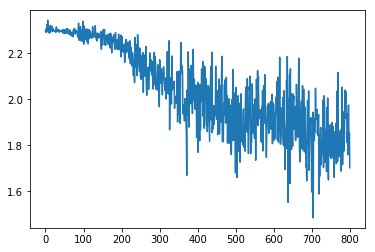

In [25]:
import matplotlib.pyplot as plt

plt.plot(loss_history)


Text(0,0.5,'Loss [entropy]')

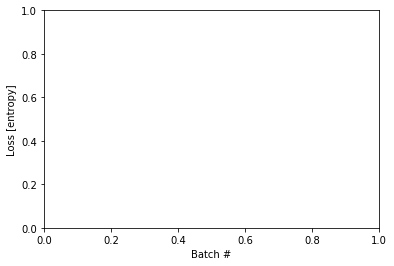

In [26]:
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [27]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

# Define:
# 1. A model.
# 2. Derivatives of a loss function with respect to model parameters.
# 3. A strategy for updating the variables based on the derivatives.
model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# Training loop
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]),
                            global_step=tf.train.get_or_create_global_step())
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 69.312
Loss at step 000: 66.589
Loss at step 020: 30.075
Loss at step 040: 13.893
Loss at step 060: 6.721
Loss at step 080: 3.541
Loss at step 100: 2.132
Loss at step 120: 1.507
Loss at step 140: 1.230
Loss at step 160: 1.107
Loss at step 180: 1.053
Loss at step 200: 1.029
Loss at step 220: 1.018
Loss at step 240: 1.013
Loss at step 260: 1.011
Loss at step 280: 1.010
Final loss: 1.010
W = 2.991025686264038, B = 2.0311496257781982


In [28]:
if tf.test.is_gpu_available():
  with tf.device("gpu:0"):
    v = tf.Variable(tf.random_normal([1000, 1000]))
    v = None  # v no longer takes up GPU memory

In [29]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [30]:
x.assign(2.)   # Assign a new value to the variables and save.
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [31]:
x.assign(11.)  # Change the variable after saving.

# Restore values from the checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  # => 2.0

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
